#Multivariate LSTM model

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import mysql.connector
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from tensorflow.keras.callbacks import EarlyStopping


Constructing the dataset

In [23]:
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="yahoonet",
    database="AIProject"
)

def make_multivariate_sequences(array, n_steps):
    """array shape: (timesteps, n_features)"""
    X, y = [], []
    for i in range(len(array)-n_steps):
        X.append(array[i:i+n_steps,:])      # n_steps x n_features
        y.append(array[i+n_steps,0])        # predict market_value next
    return np.array(X), np.array(y)

def make_multivariate_multistep(array, n_steps, n_future=3):
    """
    array shape: (timesteps, n_features)
    n_steps = how many past windows
    n_future = how many steps ahead to predict (e.g., next 3 windows)
    """
    X, y = [], []
    for i in range(len(array)-n_steps-n_future+1):
        X.append(array[i:i+n_steps, :])
        y.append(array[i+n_steps:i+n_steps+n_future, 0])  # future market_value only
    return np.array(X), np.array(y)

# --- Load the merged time series ---
# (Here df_t is the transfer history with date & market_value)
# (df_f is the player_features table with static columns)

df_t = pd.read_sql("SELECT transfermarkt_id, transfer_date, market_value FROM player_transfer_history ORDER BY transfermarkt_id, transfer_date", db)
df_f = pd.read_sql("SELECT * FROM player_features", db)

# Merge static features onto each time row
df = df_t.merge(df_f[["player_id","total_injuries","sentiment_mean","avg_cards_per_match","avg_days_out","recent_injury","days_since_last_injury","season_id","minutes_played","shots_per90","pressures_per90"]],
                left_on="transfermarkt_id", right_on="player_id", how="left")

# Sort by time per player
df = df.sort_values(["transfermarkt_id","transfer_date"])

df.head()

n_steps = 3
n_future = 3
X_list, y_list, player_index = [], [], []

for pid, group in df.groupby("transfermarkt_id"):
    # Select columns for features
    features = group[["market_value","total_injuries","sentiment_mean","avg_cards_per_match","avg_days_out","recent_injury","days_since_last_injury","season_id","minutes_played","shots_per90","pressures_per90"]].fillna(0).values
    
    # Scale per player for all features
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(features)

    #Xp, yp = make_multivariate_sequences(scaled, n_steps)
    Xp, yp = make_multivariate_multistep(scaled, n_steps, n_future)
    if len(Xp)==0:
        continue
    X_list.append(Xp)
    y_list.append(yp)
    player_index.extend([pid]*len(yp))

# Stack across all players
#X = np.vstack(X_list)   # shape: (samples, n_steps, n_features)
#y = np.concatenate(y_list)  # shape: (samples,)

X = np.vstack(X_list)   # (samples, n_steps, n_features)
y = np.vstack(y_list)   # (samples, n_future)



C:\Users\Himanshu Saxena\AppData\Local\Temp\ipykernel_37128\1035311267.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_t = pd.read_sql("SELECT transfermarkt_id, transfer_date, market_value FROM player_transfer_history ORDER BY transfermarkt_id, transfer_date", db)
C:\Users\Himanshu Saxena\AppData\Local\Temp\ipykernel_37128\1035311267.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_f = pd.read_sql("SELECT * FROM player_features", db)


Check for missing values

In [24]:
print(df.isnull().sum())

transfermarkt_id          0
transfer_date             0
market_value              0
player_id                 0
total_injuries            0
sentiment_mean            0
avg_cards_per_match       0
avg_days_out              0
recent_injury             0
days_since_last_injury    0
season_id                 0
minutes_played            0
shots_per90               0
pressures_per90           0
dtype: int64


LSTM Building

In [25]:
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(n_future))   # output n_future steps
model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, shuffle=True, callbacks=[es])


#history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, shuffle=True)

"""
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
"""


Epoch 1/50


C:\Users\Himanshu Saxena\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1475 - val_loss: 0.1271
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1046 - val_loss: 0.1241
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1020 - val_loss: 0.1266
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0991 - val_loss: 0.1175
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0964 - val_loss: 0.1211
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0955 - val_loss: 0.1188
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0953 - val_loss: 0.1129
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0946 - val_loss: 0.1170
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0949 - val_loss: 0.1160
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0940 - val_loss: 0.1191
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0938 - val_loss: 0.1121
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0942 - val_loss: 0.1131


"\nplt.plot(history.history['loss'], label='train')\nplt.plot(history.history['val_loss'], label='val')\nplt.legend()\nplt.show()\n"

Training + Loss curves

In [26]:
"""
# Plot loss curves
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Loss Curves')
plt.show()
"""

"\n# Plot loss curves\nplt.figure(figsize=(6,4))\nplt.plot(history.history['loss'], label='Train Loss')\nplt.plot(history.history['val_loss'], label='Validation Loss')\nplt.xlabel('Epoch')\nplt.ylabel('MSE')\nplt.legend()\nplt.title('Loss Curves')\nplt.show()\n"

RMSE

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1592 - val_loss: 0.1092
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1100 - val_loss: 0.1068
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1061 - val_loss: 0.1048
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1030 - val_loss: 0.1025
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1003 - val_loss: 0.1023
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0993 - val_loss: 0.1033
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0981 - val_loss: 0.1021
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0982 - val_loss: 0.1019
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0985 - val_loss: 0.1017
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0975 - val_loss: 0.1017
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0970 - val_loss: 0.1017
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0969 - val_lo

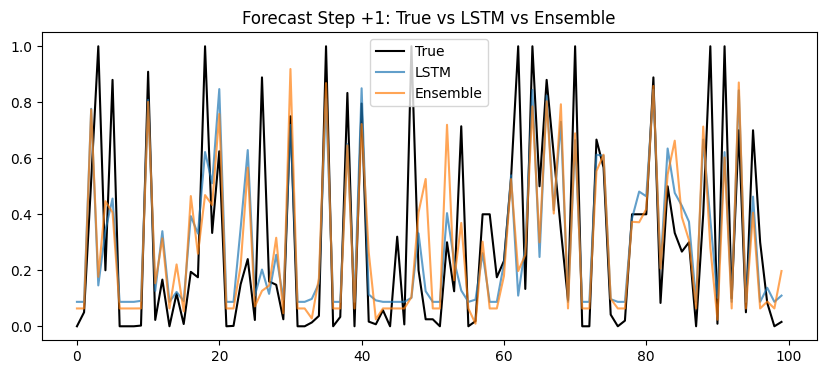


=== Forecast Step +2 ===
RMSE LSTM: 0.3222
RMSE Ensemble: 0.3283


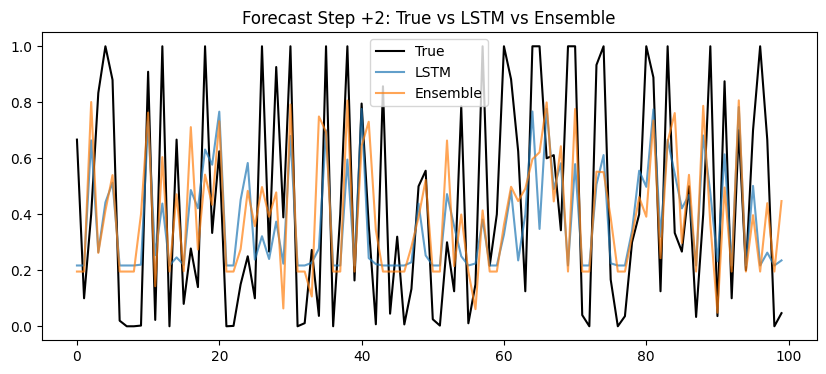


=== Forecast Step +3 ===
RMSE LSTM: 0.3658
RMSE Ensemble: 0.3734


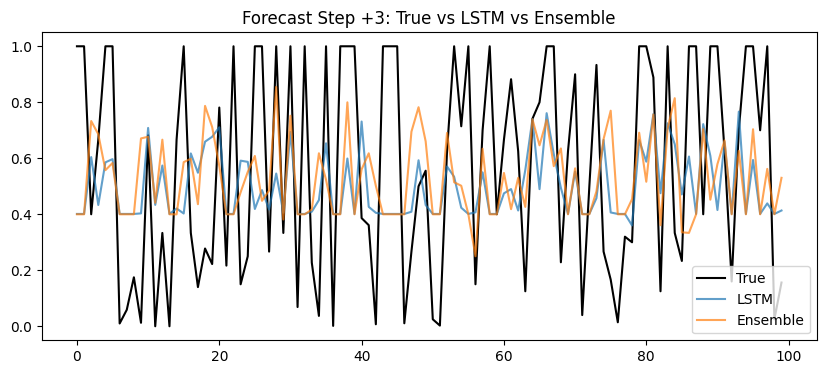


RMSE Comparison Across Horizons:
        RMSE_LSTM  RMSE_Ensemble
Step+1   0.243344       0.251969
Step+2   0.322175       0.328322
Step+3   0.365791       0.373355


: 

In [ ]:
# Evaluate RMSE on validation set

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(n_future))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val,y_val))

y_val_pred_lstm = model.predict(X_val)

# compute RMSE for each horizon
#rmse_per_step = np.sqrt(np.mean((y_val - y_val_pred_lstm)**2, axis=0))
#print("RMSE per forecast step:", rmse_per_step)

##############
# Flatten time windows to one row per sample
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# LSTM predictions for train set
y_train_pred_lstm = model.predict(X_train)


# Combine as meta-features
train_meta = np.hstack([X_train_flat, y_train_pred_lstm])
val_meta = np.hstack([X_val_flat, y_val_pred_lstm])
"""
# For simplicity, start with step+1 only
y_train_step1 = y_train[:,0]
y_val_step1 = y_val[:,0]

model_xgb = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8
)
model_xgb.fit(train_meta, y_train_step1)

# Predictions
y_val_pred_xgb = model_xgb.predict(val_meta)

rmse_lstm = np.sqrt(mean_squared_error(y_val_step1, y_val_pred_lstm[:,0]))
rmse_xgb  = np.sqrt(mean_squared_error(y_val_step1, y_val_pred_xgb))

print("RMSE LSTM step+1:", rmse_lstm)
print("RMSE Ensemble step+1:", rmse_xgb)
"""

# Extended Ensemble: All Horizons

rmses = []
y_val_pred_xgb_all = []  # store predictions for plotting

for step in range(n_future):
    print(f"\n=== Forecast Step +{step+1} ===")

    # Select step-specific targets
    y_train_step = y_train[:, step]
    y_val_step = y_val[:, step]

    # Train XGBoost using meta-features
    model_xgb = xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model_xgb.fit(train_meta, y_train_step)

    # Predict on validation set
    y_val_pred_xgb = model_xgb.predict(val_meta)
    y_val_pred_xgb_all.append(y_val_pred_xgb)

    # Compare with LSTM predictions
    rmse_lstm = np.sqrt(mean_squared_error(y_val_step, y_val_pred_lstm[:, step]))
    rmse_xgb = np.sqrt(mean_squared_error(y_val_step, y_val_pred_xgb))

    print(f"RMSE LSTM: {rmse_lstm:.4f}")
    print(f"RMSE Ensemble: {rmse_xgb:.4f}")
    rmses.append((rmse_lstm, rmse_xgb))

    # Plot true vs predicted
    plt.figure(figsize=(10,4))
    plt.plot(y_val_step[:100], label='True', color='black')
    plt.plot(y_val_pred_lstm[:100, step], label='LSTM', alpha=0.7)
    plt.plot(y_val_pred_xgb[:100], label='Ensemble', alpha=0.7)
    plt.legend()
    plt.title(f"Forecast Step +{step+1}: True vs LSTM vs Ensemble")
    plt.show()

# Store RMSEs in dataframe
rmse_df = pd.DataFrame(rmses, columns=["RMSE_LSTM", "RMSE_Ensemble"])
rmse_df.index = [f"Step+{i+1}" for i in range(n_future)]
print("\nRMSE Comparison Across Horizons:")
print(rmse_df)

